In [1]:
# %pip install torch torchvision torchaudio
# to install pytorch on jupyter

In [1]:
import numpy as np
import torch

# Phase1

- 𝑡∈[0,10] , t is a grid of time points which defeines the solution space of the differential equation 
- 

In [2]:
t_min, t_max= 0.0, 10.0
points= 200
torch.manual_seed(0)
t_grid= np.linspace(t_min, t_max,points)
t= torch.tensor(t_grid, dtype=torch.float32).view(-1,1) # shape is 200,1

#### defining initial conditions

In [3]:
# runu this on your pc, you need this
x0, v0 = 1.0, 0.0

t_ic= torch.tensor([[0.0]], dtype=torch.float32)    # time= 0
x_ic= torch.tensor([[x0]], dtype=torch.float32)     # displacement at t=0 is x=1
v_ic= torch.tensor([[v0]], dtype=torch.float32)

#### Collocation Points (Physics Loss)
- Collocation points are artificially chosen points inside the problem’s domain (here, the time interval[0,10]) where the neural network is forced to satisfy the given differential equation.
- Instead of training only on data (like in normal ML), we also enforce the Ordinary Differential Equation(ODE) itself
- To do this, we sample collocation points inside the time interval  𝑡∈[0,10]
- At each collocation point, we ask the network: Does predicte x(t) satisfy the differential equation

In [4]:
# do not run this cell again. go to next cell
n_collocationPoints= 100
torch.manual_seed(0)
t_collocation= torch.rand(n_collocationPoints, 1) * (t_max-t_min) + t_min

In [ ]:
# do not run this
#torch.save(t_collocation, "collocation.pt")

# PHASE 2

The equation we need to solve is the residual of an ordinary differential equation(ode) :
$$
R(t) = \frac{d^2x}{dt^2} + 2\zeta\omega \frac{dx}{dt} + \omega^2 x
$$
where,  
x(t): Displacement (or general dynamic variable)    
$\omega$ : Undamped natural frequency (rad/s)   
$\zeta$ : Damping ratio (dimensionless)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# to use the collocation points, do t_collocation= torch.load("collocation.pt")
t_collocation= torch.load("collocation.pt")  # use this 

In [7]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
omega = 1.0    # natural frequency
zeta  = 0.1    # damping ratio (<1, underdamped). Adjusted as per need

In [9]:
nHidden_layers= 4
hidden_neurons= 32 
activation= torch.tanh  #for smooth derivatives

In [10]:
activation_layer = activation if isinstance(activation, nn.Module) else nn.Tanh()

class PINN_MLP(nn.Module):
    def __init__(self, nhidden_layers=2, hidden_neurons=20, activation=nn.Tanh()):
        super().__init__()
        
        layers = []

        # input layer
        layers.append(nn.Linear(1, hidden_neurons))
        layers.append(activation)
        # hidden layers

        for _ in range(max(0, nhidden_layers - 1)):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(activation)
        # output layer
        
        layers.append(nn.Linear(hidden_neurons, 1))
        self.net = nn.Sequential(*layers)

        # weights initialization
        self.apply(self._init_weights)

    def forward(self, t):
        return self.net(t)
    
    @staticmethod   #belongs t othe class, not its instance
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

In [11]:
model= PINN_MLP(nHidden_layers,hidden_neurons,activation_layer).to(device)

Output of model is: 
$
\hat{u}(t) = f(t; \theta)
$


In [12]:
def derivatives(model, t_in):
    #returns x, dx/dt, d2x/dt2

    t= t_in.clone().detach().requires_grad_(True).to(device)
    x= model(t)

    dx= torch.autograd.grad(outputs=x, inputs=t,
                            grad_outputs=torch.ones_like(x),
                            create_graph=True,retain_graph=True)[0]
    
    #2nd derivative
    ddx= torch.autograd.grad(outputs=dx, inputs=t,
                            grad_outputs=torch.ones_like(dx),
                            create_graph=True,retain_graph=True)[0]
    
    return x,dx,ddx

In [13]:
def pinn_loss(model, t_ic, x_ic, v_ic,t_collocation,omega,zeta):
    t_ic_req = t_ic.clone().detach().requires_grad_(True).to(device)
    x_pred_ic = model(t_ic_req)   # predicted x(0)
    # dx/dt at t_ic
    dx_ic = torch.autograd.grad(outputs=x_pred_ic, inputs=t_ic_req,
                                grad_outputs=torch.ones_like(x_pred_ic),
                                create_graph=True)[0]
    ic_loss = F.mse_loss(x_pred_ic, x_ic.to(device)) + F.mse_loss(dx_ic, v_ic.to(device))

    # Physics loss (collocation points)
    t_col_req = t_collocation.clone().detach().requires_grad_(True).to(device)
    x_col, dx_col, ddx_col = derivatives(model, t_col_req)

    # Residual R(t) 
    res = ddx_col + 2.0 * zeta * omega * dx_col + (omega ** 2) * x_col
    physics_loss = torch.mean(res ** 2)

    total_loss = ic_loss + physics_loss
    return total_loss, ic_loss, physics_loss


In [14]:
t_collocation = t_collocation.to(device)
t = t.to(device)
t_ic = t_ic.to(device)
x_ic = x_ic.to(device)
v_ic = v_ic.to(device)

In [27]:
t_collocation = t_collocation.clamp(min=t.min().item(), max=t.max().item())

# forward & loss check
model.train()
total, ic_l, phys_l = pinn_loss(model, t_ic, x_ic, v_ic, t_collocation[:200], omega, zeta)  # small subset for quick check
print("Quick check -> total_loss:", total.item(), "ic_loss:", ic_l.item(), "physics_loss:", phys_l.item())

# verifying derivatives at a test point 
t_test = torch.tensor([[0.5]], dtype=torch.float32).to(device)
x_t, dx_t, ddx_t = derivatives(model, t_test)
print("At t=0.5 -> x:", x_t.item(), "dx:", dx_t.item(), "ddx:", ddx_t.item())

Quick check -> total_loss: 1.533272097731242e-06 ic_loss: 5.227387305239972e-07 physics_loss: 1.0105334240506636e-06
At t=0.5 -> x: 0.8821245431900024 dx: -0.45588868856430054 ddx: -0.7893925905227661


In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10000 #2000
print_interval = 200

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    total_loss, ic_loss, phys_loss = pinn_loss(model, t_ic, x_ic, v_ic, t_collocation, omega, zeta)
    total_loss.backward()
    optimizer.step()

    if epoch % print_interval == 0 or epoch == 1:
        print(f"Epoch {epoch:04d} | total: {total_loss.item():.6e} | ic: {ic_loss.item():.6e} | phys: {phys_loss.item():.6e}")

Epoch 0001 | total: 1.533272e-06 | ic: 5.227387e-07 | phys: 1.010533e-06
Epoch 0200 | total: 4.483568e-07 | ic: 1.598233e-10 | phys: 4.481970e-07
Epoch 0400 | total: 2.640579e-07 | ic: 4.311573e-11 | phys: 2.640148e-07
Epoch 0600 | total: 1.970888e-07 | ic: 1.803713e-11 | phys: 1.970707e-07
Epoch 0800 | total: 3.363597e-06 | ic: 1.869296e-06 | phys: 1.494302e-06
Epoch 1000 | total: 1.931630e-06 | ic: 1.059908e-06 | phys: 8.717219e-07
Epoch 1200 | total: 1.502746e-07 | ic: 1.218845e-08 | phys: 1.380861e-07
Epoch 1400 | total: 1.350968e-06 | ic: 7.019627e-07 | phys: 6.490050e-07
Epoch 1600 | total: 7.067157e-06 | ic: 4.209289e-06 | phys: 2.857868e-06
Epoch 1800 | total: 1.196290e-05 | ic: 6.665468e-06 | phys: 5.297433e-06
Epoch 2000 | total: 9.965723e-08 | ic: 2.035501e-10 | phys: 9.945368e-08
Epoch 2200 | total: 2.682485e-07 | ic: 6.501537e-08 | phys: 2.032331e-07
Epoch 2400 | total: 3.155287e-05 | ic: 1.292118e-05 | phys: 1.863169e-05
Epoch 2600 | total: 1.769216e-07 | ic: 1.599064e-08

# Phase 3

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [30]:
model.eval() 

PINN_MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [31]:
with torch.no_grad():
    x_pred = model(t) 

In [32]:
x0 = 1.0
v0 = 0.0
omega = 1.0
zeta = 0.1

In [33]:
# Damped frequency
omega_d = omega * np.sqrt(1 - zeta**2)

t_np = t.cpu().numpy()  # convert PyTorch tensor to NumPy array for formula
x_true = np.exp(-zeta * omega * t_np) * (
    x0 * np.cos(omega_d * t_np) +
    (v0 + zeta * omega * x0) / omega_d * np.sin(omega_d * t_np)
)

In [35]:
x_pred_np = x_pred.cpu().numpy()  # convert tensor to NumPy for error calc

mse = mean_squared_error(x_true, x_pred_np)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.6e}, RMSE: {rmse:.6e}")

MSE: 4.620379e-07, RMSE: 6.797337e-04


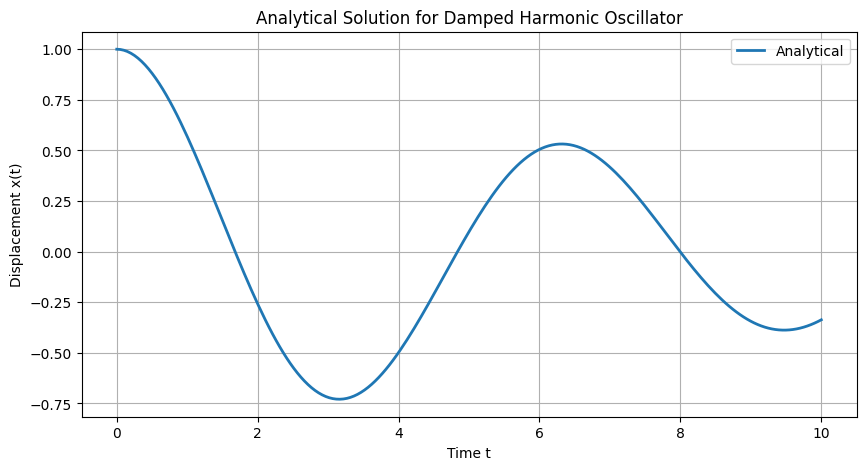

In [24]:
plt.figure(figsize=(10,5))
plt.plot(t_np, x_true, label="Analytical", linewidth=2)
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.title("Analytical Solution for Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()


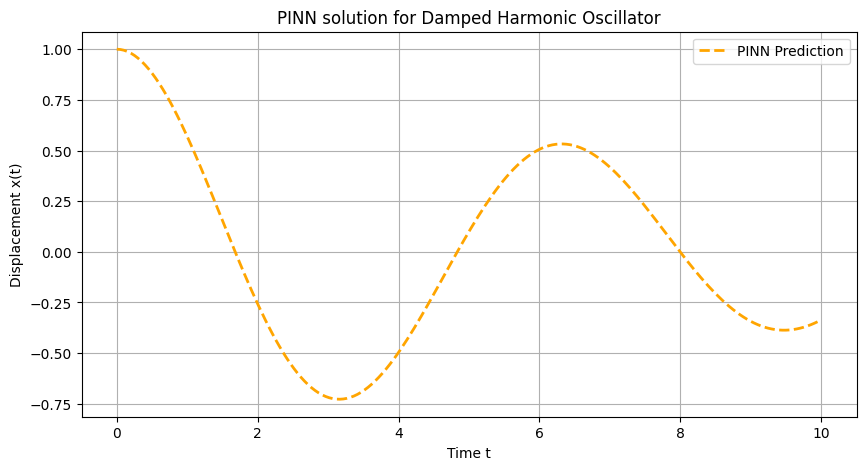

In [25]:
plt.figure(figsize=(10,5))
plt.plot(t_np, x_pred_np, '--', label="PINN Prediction", linewidth=2, color='orange')
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.title("PINN solution for Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()


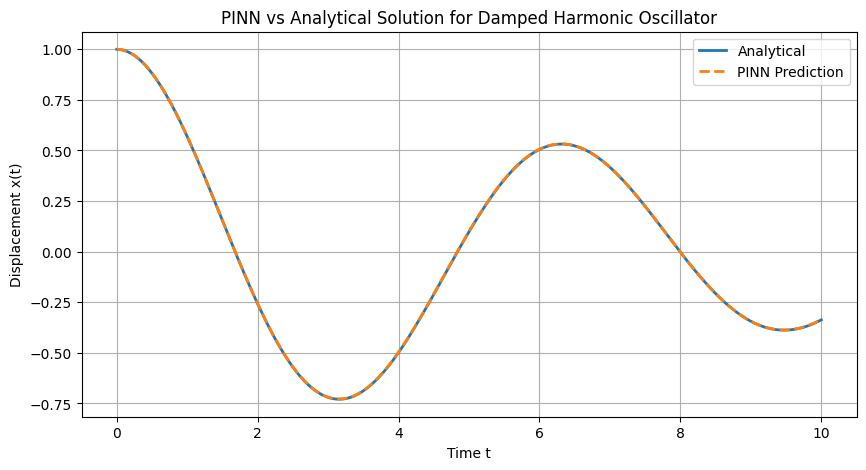

In [26]:
plt.figure(figsize=(10,5))
plt.plot(t_np, x_true, label="Analytical", linewidth=2)
plt.plot(t_np, x_pred_np, '--', label="PINN Prediction", linewidth=2)
plt.xlabel("Time t")
plt.ylabel("Displacement x(t)")
plt.title("PINN vs Analytical Solution for Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()


### Annealing
- Annealing in neural networks refers to a class of optimization techniques inspired by the physical process of annealing, where a material is heated and then slowly cooled to reduce defects and achieve a stable, low-energy state. 
- This principle is applied to improve the training of neural networks by avoiding local minima and finding better solutions


In [36]:
# Annealing- intuitive approach where you change the weights based on the training progress
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10000 
print_interval = 500

num_annealing_epochs = n_epochs // 2
start_w_phys = 0.01 # Starting with a small weight for physics
end_w_phys = 1.0    # End with full weight

print(f"Annealing physics loss weight from {start_w_phys} to {end_w_phys} over {num_annealing_epochs} epochs.")

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()

    # original losses without back-prop
    total_loss, ic_loss, phys_loss = pinn_loss(model, t_ic, x_ic, v_ic, t_collocation, omega, zeta)

    w_ic = 1.0 # initial condition weight fixed

    if epoch <= num_annealing_epochs:
        w_phys = start_w_phys + (end_w_phys - start_w_phys) * (epoch / num_annealing_epochs)
    else:
        w_phys = end_w_phys # keeping max weight after annealing period

    # Weighted Loss calculation
    total_loss_weighted = w_ic * ic_loss + w_phys * phys_loss

    # back prop
    total_loss_weighted.backward()
    optimizer.step()

    if epoch % print_interval == 0 or epoch == 1:
        print(f"Epoch {epoch:04d} | total_w: {total_loss_weighted.item():.6e} | ic: {ic_loss.item():.6e} | phys: {phys_loss.item():.6e} | w_phys: {w_phys:.3f}")


Annealing physics loss weight from 0.01 to 1.0 over 5000 epochs.
Epoch 0001 | total_w: 2.990353e-07 | ic: 2.942177e-07 | phys: 4.724097e-07 | w_phys: 0.010
Epoch 0500 | total_w: 2.664407e-08 | ic: 1.044720e-12 | phys: 2.444314e-07 | w_phys: 0.109
Epoch 1000 | total_w: 2.825821e-08 | ic: 2.982722e-09 | phys: 1.215168e-07 | w_phys: 0.208
Epoch 1500 | total_w: 2.981235e-08 | ic: 4.695049e-10 | phys: 9.557929e-08 | w_phys: 0.307
Epoch 2000 | total_w: 4.763523e-06 | ic: 3.786192e-06 | phys: 2.407217e-06 | w_phys: 0.406
Epoch 2500 | total_w: 8.649261e-06 | ic: 5.306744e-06 | phys: 6.618845e-06 | w_phys: 0.505
Epoch 3000 | total_w: 7.163503e-08 | ic: 7.470764e-09 | phys: 1.062322e-07 | w_phys: 0.604
Epoch 3500 | total_w: 8.601917e-07 | ic: 2.946626e-07 | phys: 8.044511e-07 | w_phys: 0.703
Epoch 4000 | total_w: 3.306336e-05 | ic: 9.142360e-06 | phys: 2.982669e-05 | w_phys: 0.802
Epoch 4500 | total_w: 2.248415e-05 | ic: 1.274911e-05 | phys: 1.080470e-05 | w_phys: 0.901
Epoch 5000 | total_w: 1.4

In [37]:
model.eval()
with torch.no_grad():
    x_pred_anneal = model(t) 

x_pred_anneal_np = x_pred_anneal.cpu().numpy() 
mse_anneal = mean_squared_error(x_true, x_pred_anneal_np)
rmse_anneal = np.sqrt(mse_anneal)

print("------Annealing results------")
print(f"MSE: {mse_anneal:.6e}, RMSE: {rmse_anneal:.6e}")

------Annealing results------
MSE: 5.222544e-08, RMSE: 2.285288e-04
